In [33]:
import math
from random import seed
import os
import pandas as pd
from itertools import combinations
import scipy.cluster.hierarchy as sch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy.stats import hypergeom
from sklearn.preprocessing import StandardScaler
from collections import Counter
from scipy.cluster import hierarchy
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import xlsxwriter

In [ ]:
#set seed for reproducibility
np.random.seed(42)

In [34]:
snp_directory_path = 'FUMA_dowloads_all_tissue/SNPs'
eqtl_directory_path = 'FUMA_dowloads_all_tissue/eQTL'

# Initialize list to store merged dataframes
merged_dfs = []

# Iterate through SNP and eQTL directories simultaneously
for snp_file, eqtl_file in zip(os.listdir(snp_directory_path), os.listdir(eqtl_directory_path)):
    if snp_file.endswith('.txt') and eqtl_file.endswith('.txt'):
        # Extract disorder name from the filename
        disorder_name = snp_file.split('_')[1].split('.')[0]

        # Read SNP and eQTL files
        snp_df = pd.read_csv(os.path.join(snp_directory_path, snp_file), sep='\t')
        eqtl_df = pd.read_csv(os.path.join(eqtl_directory_path, eqtl_file), sep='\t', low_memory=False)

        # Choose columns of interest in each dataframe
        snp_df = snp_df[['uniqID', 'rsID', 'gwasP']].dropna().drop_duplicates()
        eqtl_df = eqtl_df[['uniqID', 'symbol', 'tissue']].dropna().drop_duplicates()

        # Merge SNP and eQTL dataframes on 'uniqID'
        merged_df = pd.merge(snp_df, eqtl_df, on='uniqID', how='inner')

        # Add disorder column
        merged_df['disorder'] = disorder_name

        # Append the merged dataframe to the list
        merged_dfs.append(merged_df)

In [37]:
len(merged_dfs)

32

In [38]:
def make_binary_matrix(df_list, column1,column2):
    concatenated= pd.concat(df_list)
    df = concatenated[[column1, column2]]
    
    return df.pivot_table(index=column1, columns=column2, aggfunc=lambda x: 1, fill_value=0)

In [39]:
all_snps_binary = make_binary_matrix(merged_dfs, 'rsID', 'disorder')
all_genes_binary = make_binary_matrix(merged_dfs,'symbol', 'disorder')
""" psych_snps_binary = make_binary_matrix(psych_snp_dfs,'rsID', 'disorder')
genes_psych_binary = make_binary_matrix(psych_genes_dfs,'symbol', 'disorder') """

" psych_snps_binary = make_binary_matrix(psych_snp_dfs,'rsID', 'disorder')\ngenes_psych_binary = make_binary_matrix(psych_genes_dfs,'symbol', 'disorder') "

In [40]:
print(all_snps_binary.sum(axis=0))


disorder
ADHD                 4697
ANOREXIA             1926
ANXIETY                56
ARTHRITIS           12523
ASD                  3669
AUD                  5609
BILIARYCHIRROSIS     9496
BPD                 21579
CHRONICPAIN          4587
CUD                   493
ENDOMETRIOSIS        1170
EPILEPSY              454
FATIGUE               150
GDM                   812
GH                    354
GOUT                  240
HOARDING               46
IBD                    90
IBS                   390
LUPUS               16680
MDD                  9652
MIGRAINE             2028
MS                   1273
MYASTHENIAGRAVIS      101
OCD                    97
PARKINSONS           5265
PREECLAMPSIA         1627
PTSD                  126
SJOGRENS              611
SZC                 33944
THYROIDDISEASE          5
TOURETTES             170
dtype: int64


In [41]:
print(all_genes_binary.sum(axis=0))
#all_genes_binary.to_csv('all_genes_binary.csv')

disorder
ADHD                 838
ANOREXIA             343
ANXIETY               33
ARTHRITIS           2359
ASD                  231
AUD                  464
BILIARYCHIRROSIS    2087
BPD                 2413
CHRONICPAIN          433
CUD                  229
ENDOMETRIOSIS        102
EPILEPSY              26
FATIGUE               49
GDM                   76
GH                    38
GOUT                 161
HOARDING              32
IBD                   73
IBS                   23
LUPUS               1865
MDD                 1197
MIGRAINE             436
MS                  1250
MYASTHENIAGRAVIS      45
OCD                   32
PARKINSONS           560
PREECLAMPSIA         655
PTSD                  77
SJOGRENS              69
SZC                 3514
THYROIDDISEASE         8
TOURETTES            106
dtype: int64


In [42]:
def find_max_row(binary_df):
    row_sums = binary_df.sum(axis=1)

    # Find the maximum sum
    max_row_sum = row_sums.max()
    
    print("Maximum number of 1's in the row:", max_row_sum)
    return max_row_sum

In [43]:
max_combo_snps = find_max_row(all_snps_binary)
max_combo_genes = find_max_row(all_genes_binary)

Maximum number of 1's in the row: 6
Maximum number of 1's in the row: 12


In [ ]:
def count_combos(binary_df, max_combo):

    num_iterations = 10

    # Get all possible combinations of disorders
    all_combinations = []
    for r in range(2,max_combo):
        all_combinations.extend(list(combinations(binary_df.columns, r)))

    # Create an empty DataFrame with rows as each combination and columns for storing counts in each iteration
    counts_df = pd.DataFrame(index=all_combinations, columns=range(1,num_iterations+1))

    # Perform the iterations
    for i in range(1,num_iterations+1):
        # Permute the columns independently
        permuted_df = binary_df.apply(np.random.permutation, axis=0)

        iteration_counts = []

        # Count occurrences for each combination in this iteration
        for combo in all_combinations:
            # Check if all disorders in the combination are present in each row
            count = (permuted_df[list(combo)] == 1).all(axis=1).sum()
            iteration_counts.append(count)

        # Store the counts for this iteration in the dataFrame
        counts_df[i] = iteration_counts

    return counts_df

In [ ]:
def count_combos_real_data(binary_df, max_combo):
#Count all occurrences for each combination and store in a new dataframe

    # Get all possible combinations of disorders 
    all_combinations = []
    for r in range(2,max_combo):
        all_combinations.extend(list(combinations(binary_df.columns, r)))
        
    #Create empty dataframe to store the count
    count_df = pd.DataFrame(index=all_combinations, columns=['Count'])

    iteration_counts = []

    # Count occurrences for each combination in this iteration 
    for combo in all_combinations:
        # Check if all disorders in the combination are present in each row
        count = (binary_df[list(combo)] == 1).all(axis=1).sum()
        iteration_counts.append(count)

    # Store the counts for this iteration in the counts_df DataFrame
    count_df['Count'] = iteration_counts
    
    return count_df


In [ ]:

#psych_snps_randomized = count_combos(psych_snps_binary)
#all_snps_randomized = count_combos(all_snps_binary)
#psych_genes_randomized = count_combos(genes_psych_binary)
all_genes_combo_count = count_combos_real_data(all_genes_binary, 6)
all_genes_randomized = count_combos(all_genes_binary, 6)

#psych_snps_combo_count = count_combos_real_data(psych_snps_binary)
#all_snps_combo_count = count_combos_real_data(all_snps_binary)
#psych_genes_combo_count = count_combos_real_data(genes_psych_binary)



In [ ]:
#function to calculate z-scores and sort the result

def calculate_z_score(df, df_rand, threshold, count):
    
    #calculate mean and standard deviation
    means = round(df_rand.mean(axis=1),2)
    std = round(df_rand.std(axis=1),2)

    df_rand['mean'] = means
    df_rand['std'] = std
    df_rand['actual'] = df['Count']
    
    new_df = df_rand[['actual', 'mean', 'std']]
    
    #Make copies to avoid warnings
    new_df_copy = new_df.copy()
    
    
    # Calculate Z-scores 
    new_df_copy['z-score'] = round((new_df_copy['actual'] - new_df_copy['mean']) / new_df_copy['std'],2)
    
    
    sorted_df = new_df_copy.sort_values(by='z-score', ascending=False)
    
    # Replace infinite values in the "z-score" column with NaN
    sorted_df['z-score'].replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Drop rows with NaN values in the "z-score" column
    sorted_df.dropna(subset=['z-score'], how='any', inplace=True)

    return sorted_df[(sorted_df['z-score'] >= threshold) & (sorted_df['actual'] >= count)]    

In [ ]:
#z_psych_snps2 = calculate_z_score(psych_snps_combo_count, psych_snps_randomized,2,5)
#z_all_snps2 = calculate_z_score(all_snps_combo_count, all_snps_randomized,2,5)
#z_psych_genes2 = calculate_z_score(psych_genes_combo_count, psych_genes_randomized,2,5)
z_all_genes2 = calculate_z_score(all_genes_combo_count, all_genes_randomized,2,5)

#z_psych_snps3 = calculate_z_score(psych_snps_combo_count, psych_snps_randomized,3,5)
#z_all_snps3 = calculate_z_score(all_snps_combo_count, all_snps_randomized,3,5)
#z_psych_genes3 = calculate_z_score(psych_genes_combo_count, psych_genes_randomized,3,5)
z_all_genes3 = calculate_z_score(all_genes_combo_count, all_genes_randomized,3,5)

In [ ]:
z_all_genes2.head()

In [ ]:
z_all_genes2.to_csv('genes_zscore_2.csv')
z_all_genes3.to_csv('genes_zscore_3.csv')

In [ ]:
print(len(z_all_genes2))
print(len(z_all_genes3))

In [ ]:
z = {'No. of combinations with z-value >= 2':len(z_all_genes2),'No. of combinations with z-value >= 3':len(z_all_genes3)}
z_df = pd.DataFrame(data=z, index=['Genes'])

In [ ]:
z_df

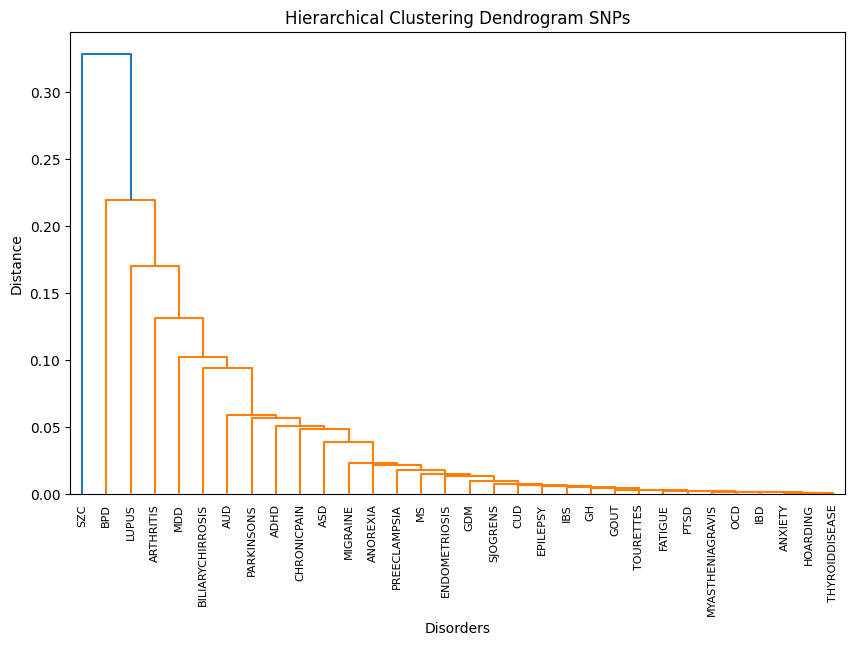

In [44]:
link = hierarchy.linkage(all_snps_binary.T, method='average', metric='hamming')
# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram = hierarchy.dendrogram(link, labels=all_snps_binary.columns)
plt.xlabel('Disorders')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram SNPs')
plt.xticks(rotation=90)
plt.show()  

In [45]:
# select top 500 SNPs ranked by significance
top_snp_list = []
for df in merged_dfs:
    sorted = df.sort_values(by=['gwasP'])
    top_snps = sorted.iloc[:500]
    top_snps.reset_index(drop=True,inplace=True)
    top_snp_list.append(top_snps)

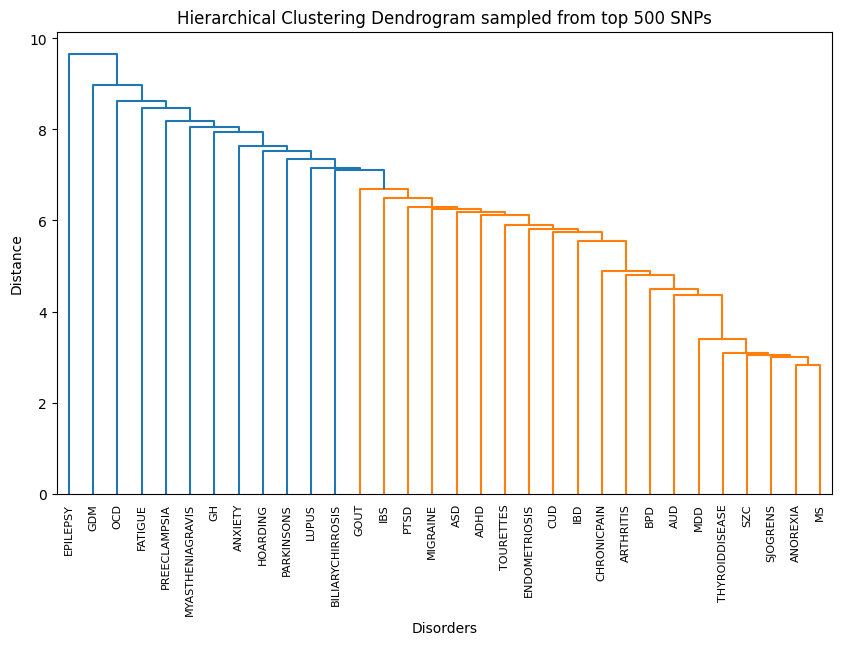

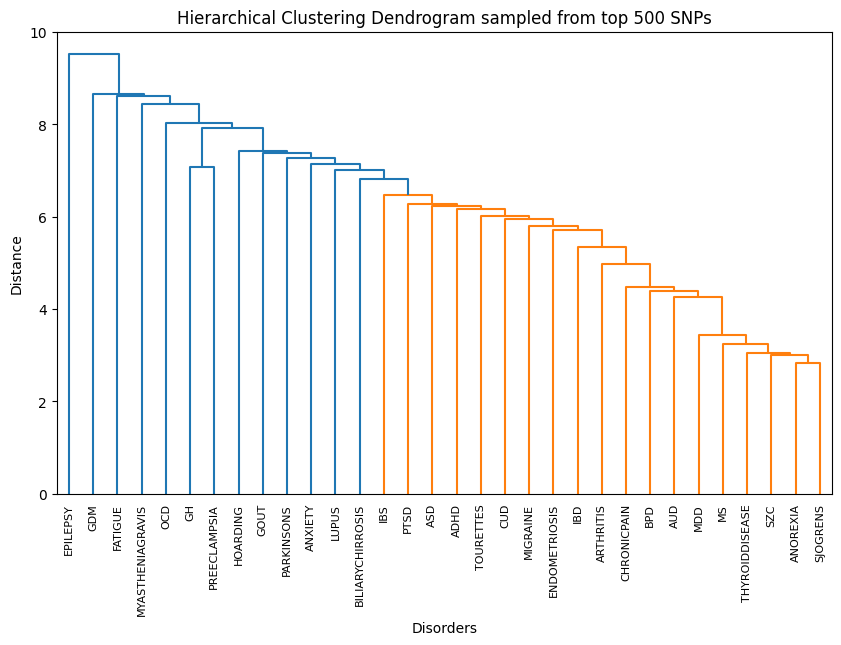

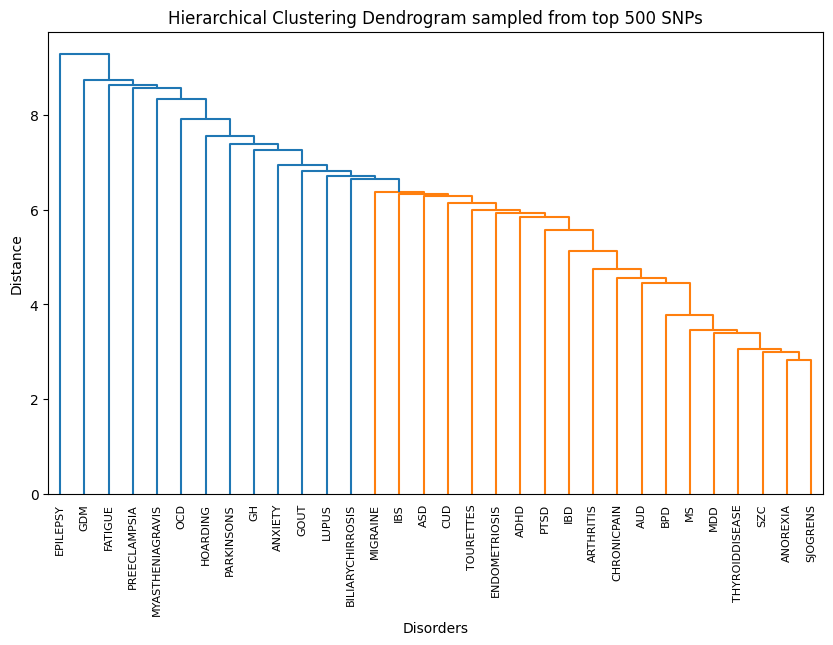

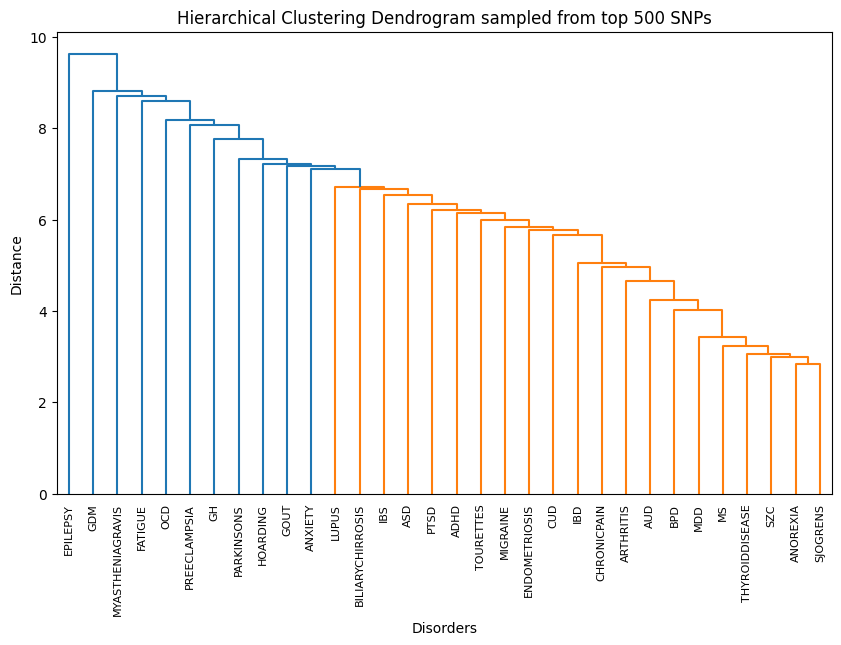

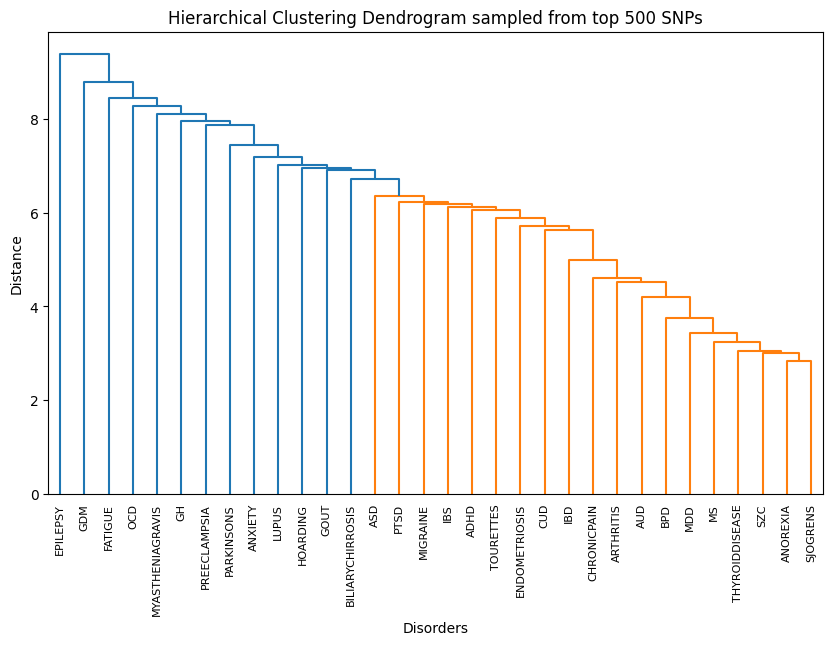

" # Compute the mean linkage matrix\nmean_linkage = np.mean(all_linkage, axis=0)\nprint(mean_linkage)\n# Plot the dendrogram for the mean linkage matrix\nplt.figure(figsize=(10, 6))\ndendrogram = hierarchy.dendrogram(mean_linkage)\nplt.xlabel('Disorders')\nplt.ylabel('Distance')\nplt.title('Consensus Hierarchical Clustering Dendrogram')\nplt.xticks(rotation=90)\nplt.show() "

In [46]:
#  randomly select a given number of SNPs

all_linkage = []

# Perform hierarchical clustering 10 times and store the linkage matrices
for _ in range(5):
    sampled_dfs = []
    for df in top_snp_list:
        sampled = df.sample(100, axis=0, replace=True)
        sampled.reset_index(inplace=True, drop=True)
        sampled_dfs.append(sampled)

    sampled_binary = make_binary_matrix(sampled_dfs, 'rsID', 'disorder')
    

    # Hierarchical clustering
    linkage_matrix = hierarchy.linkage(sampled_binary.T, method='average')
    all_linkage.append(linkage_matrix)

# Plot the dendrogram
    plt.figure(figsize=(10, 6))
    dendrogram = hierarchy.dendrogram(linkage_matrix, labels=sampled_binary.columns)
    plt.xlabel('Disorders')
    plt.ylabel('Distance')
    plt.title('Hierarchical Clustering Dendrogram sampled from top 500 SNPs')
    plt.xticks(rotation=90)
    plt.show()  

""" # Compute the mean linkage matrix
mean_linkage = np.mean(all_linkage, axis=0)
print(mean_linkage)
# Plot the dendrogram for the mean linkage matrix
plt.figure(figsize=(10, 6))
dendrogram = hierarchy.dendrogram(mean_linkage)
plt.xlabel('Disorders')
plt.ylabel('Distance')
plt.title('Consensus Hierarchical Clustering Dendrogram')
plt.xticks(rotation=90)
plt.show() """

In [ ]:
#function to find the overlaps in SNPs and genes

def find_overlaps(binary_matrix, disorders_of_interest):
    overlaps = []
    overlapping_genes = set()

    for index, row in binary_matrix.iterrows():
        ones = {col for col, val in row.items() if val == 1 and col in disorders_of_interest}

        if ones and ones == set(disorders_of_interest):
            overlaps.append((index, ones))
            overlapping_genes.add(index)

    # Write overlapping genes to a file
    with open('genes_to_enrichR.txt', 'w') as file:
        for gene in overlapping_genes:
            file.write(gene + '\n')

    return overlaps, list(overlapping_genes) 


In [ ]:
dis_of_int = ['SZC','BPD']
overlapping_genes, gene_list = find_overlaps(all_genes_binary, dis_of_int)
#overlapping_snps = find_overlaps(all_snps_binary)

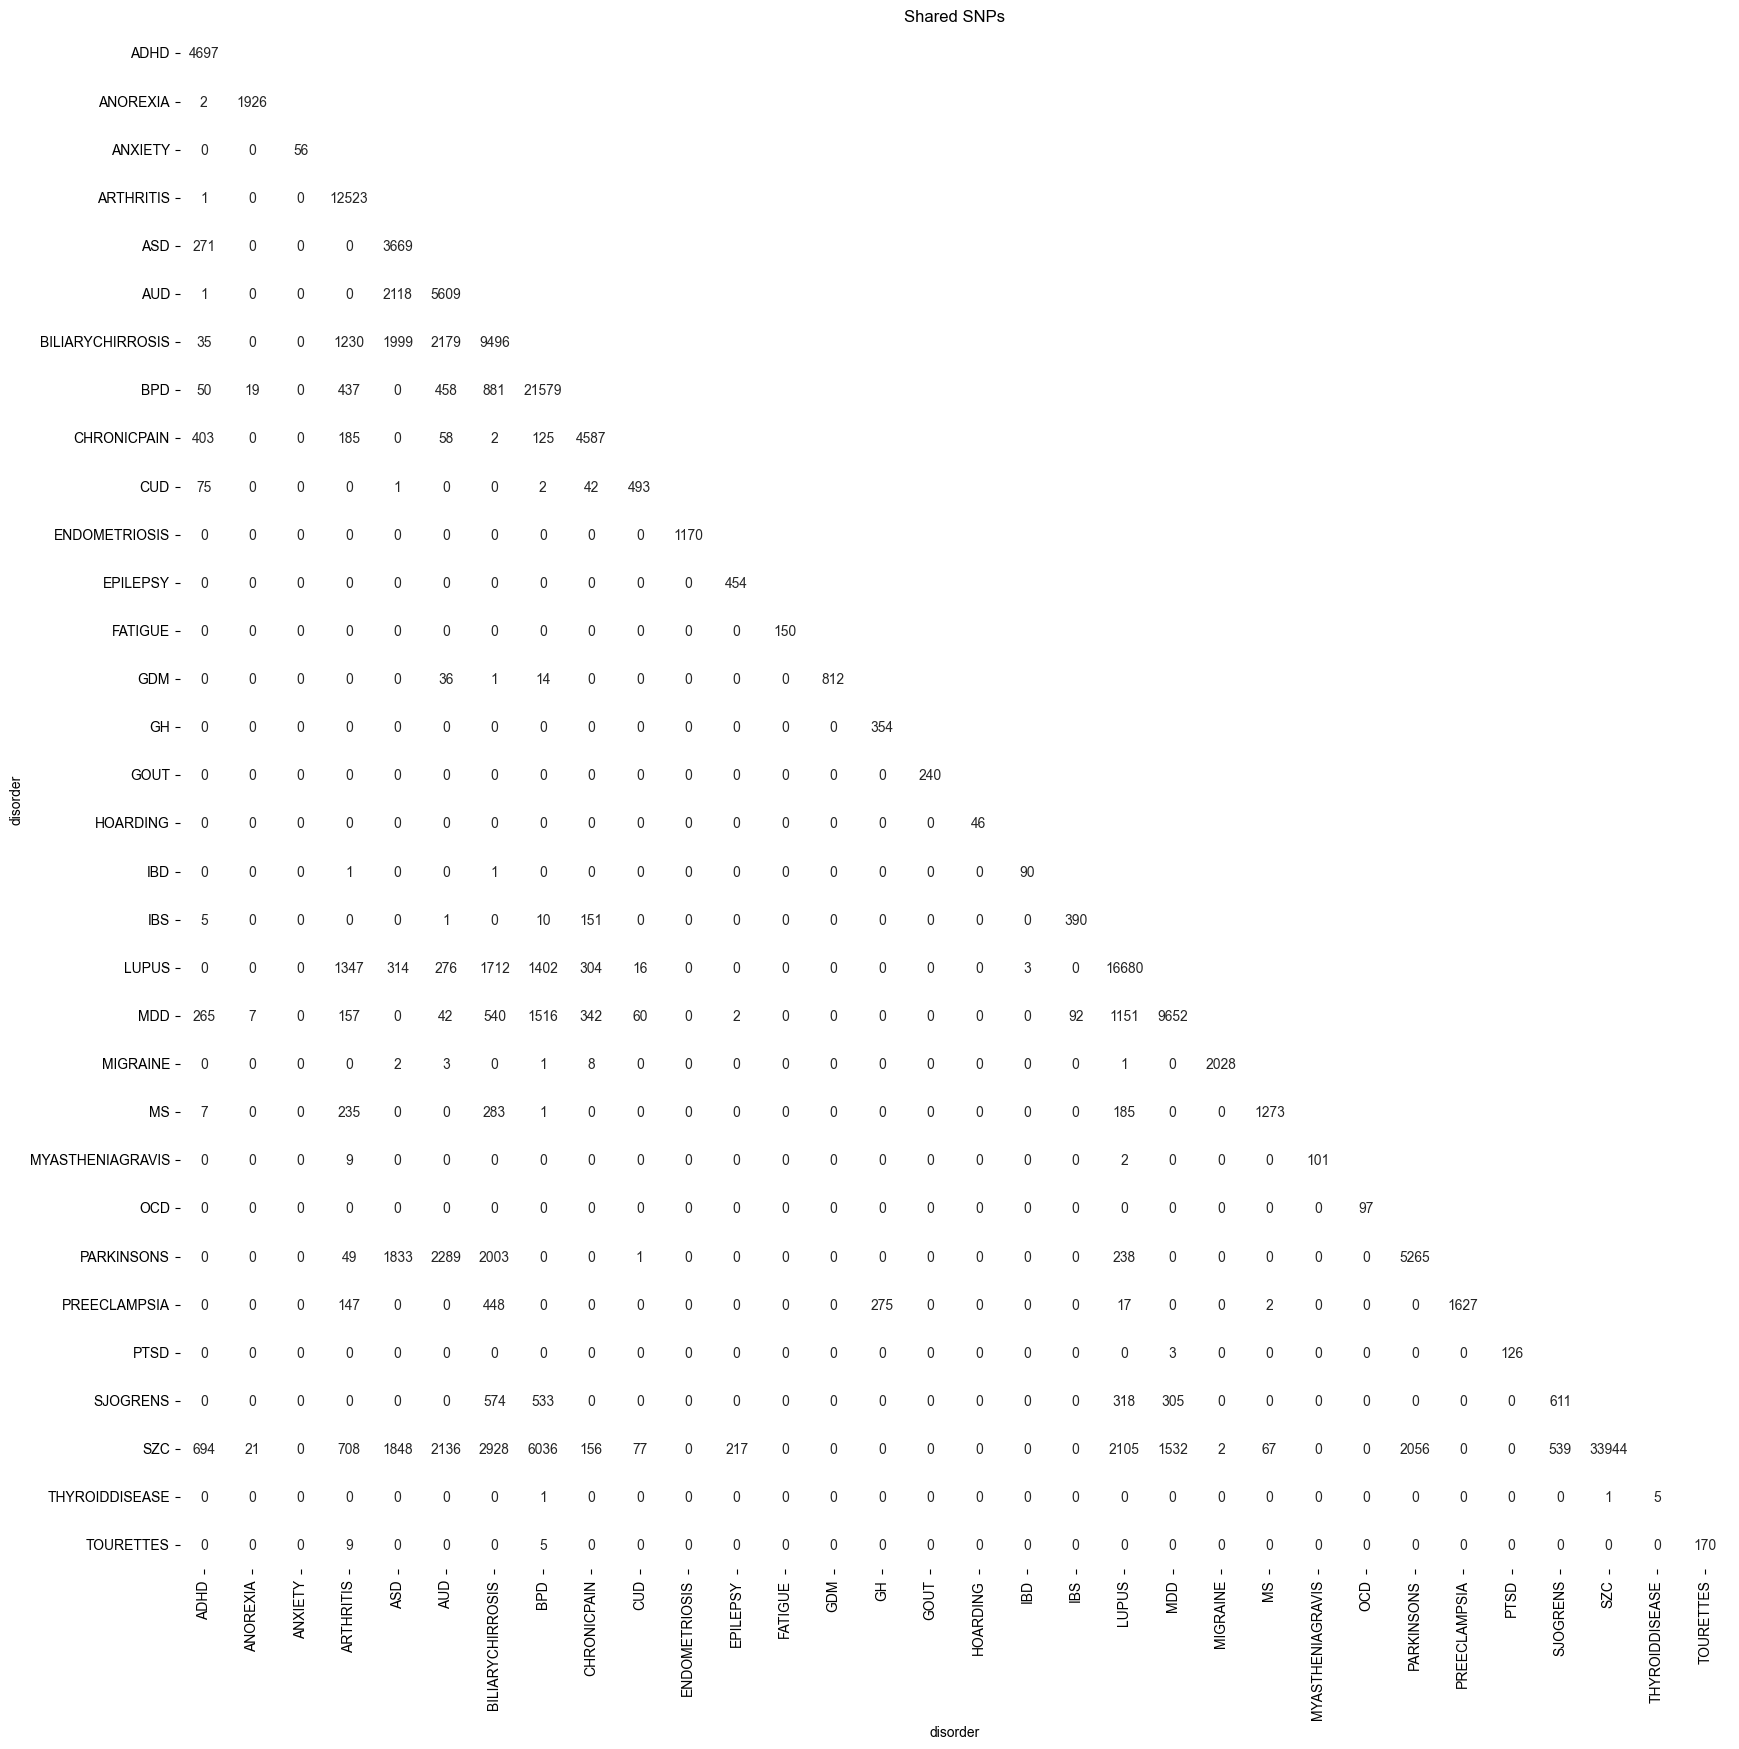

In [47]:
shared_snps = pd.DataFrame(index=all_snps_binary.columns, columns=all_snps_binary.columns, dtype=int)

#Iterate through all pairs of disorders and count genes shared
for disorder1 in all_snps_binary.columns:
    for disorder2 in all_snps_binary.columns:
        count=sum(all_snps_binary[disorder1] & all_snps_binary[disorder2])
        shared_snps.at[disorder1,disorder2] = count

#Add total number of genes in each disorder on the diagonal
for disorder in all_snps_binary.columns:
    total_count = all_snps_binary[disorder].sum()
    shared_snps.at[disorder, disorder] = total_count

#get lower triangular matrix including the diagonal
#shared_lower = pd.DataFrame(np.tril(shared_genes), index=genes_binary.columns, columns=genes_binary.columns)
disorders_snps = shared_snps.columns.tolist()
disorder_matrix_snps = shared_snps.to_numpy()

# Create a mask for the upper triangular part
mask = np.triu(np.ones_like(shared_snps), k=1).astype(bool)

# Set the values in the upper triangular part to NaN
shared_snps[mask] = np.nan

# Specify the size of the heatmap
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the heatmap
with sns.axes_style('white'):
    sns.heatmap(shared_snps, annot=True, fmt='.0f', cmap=ListedColormap(['white']), cbar=False)
    plt.title('Shared SNPs')
    plt.show()

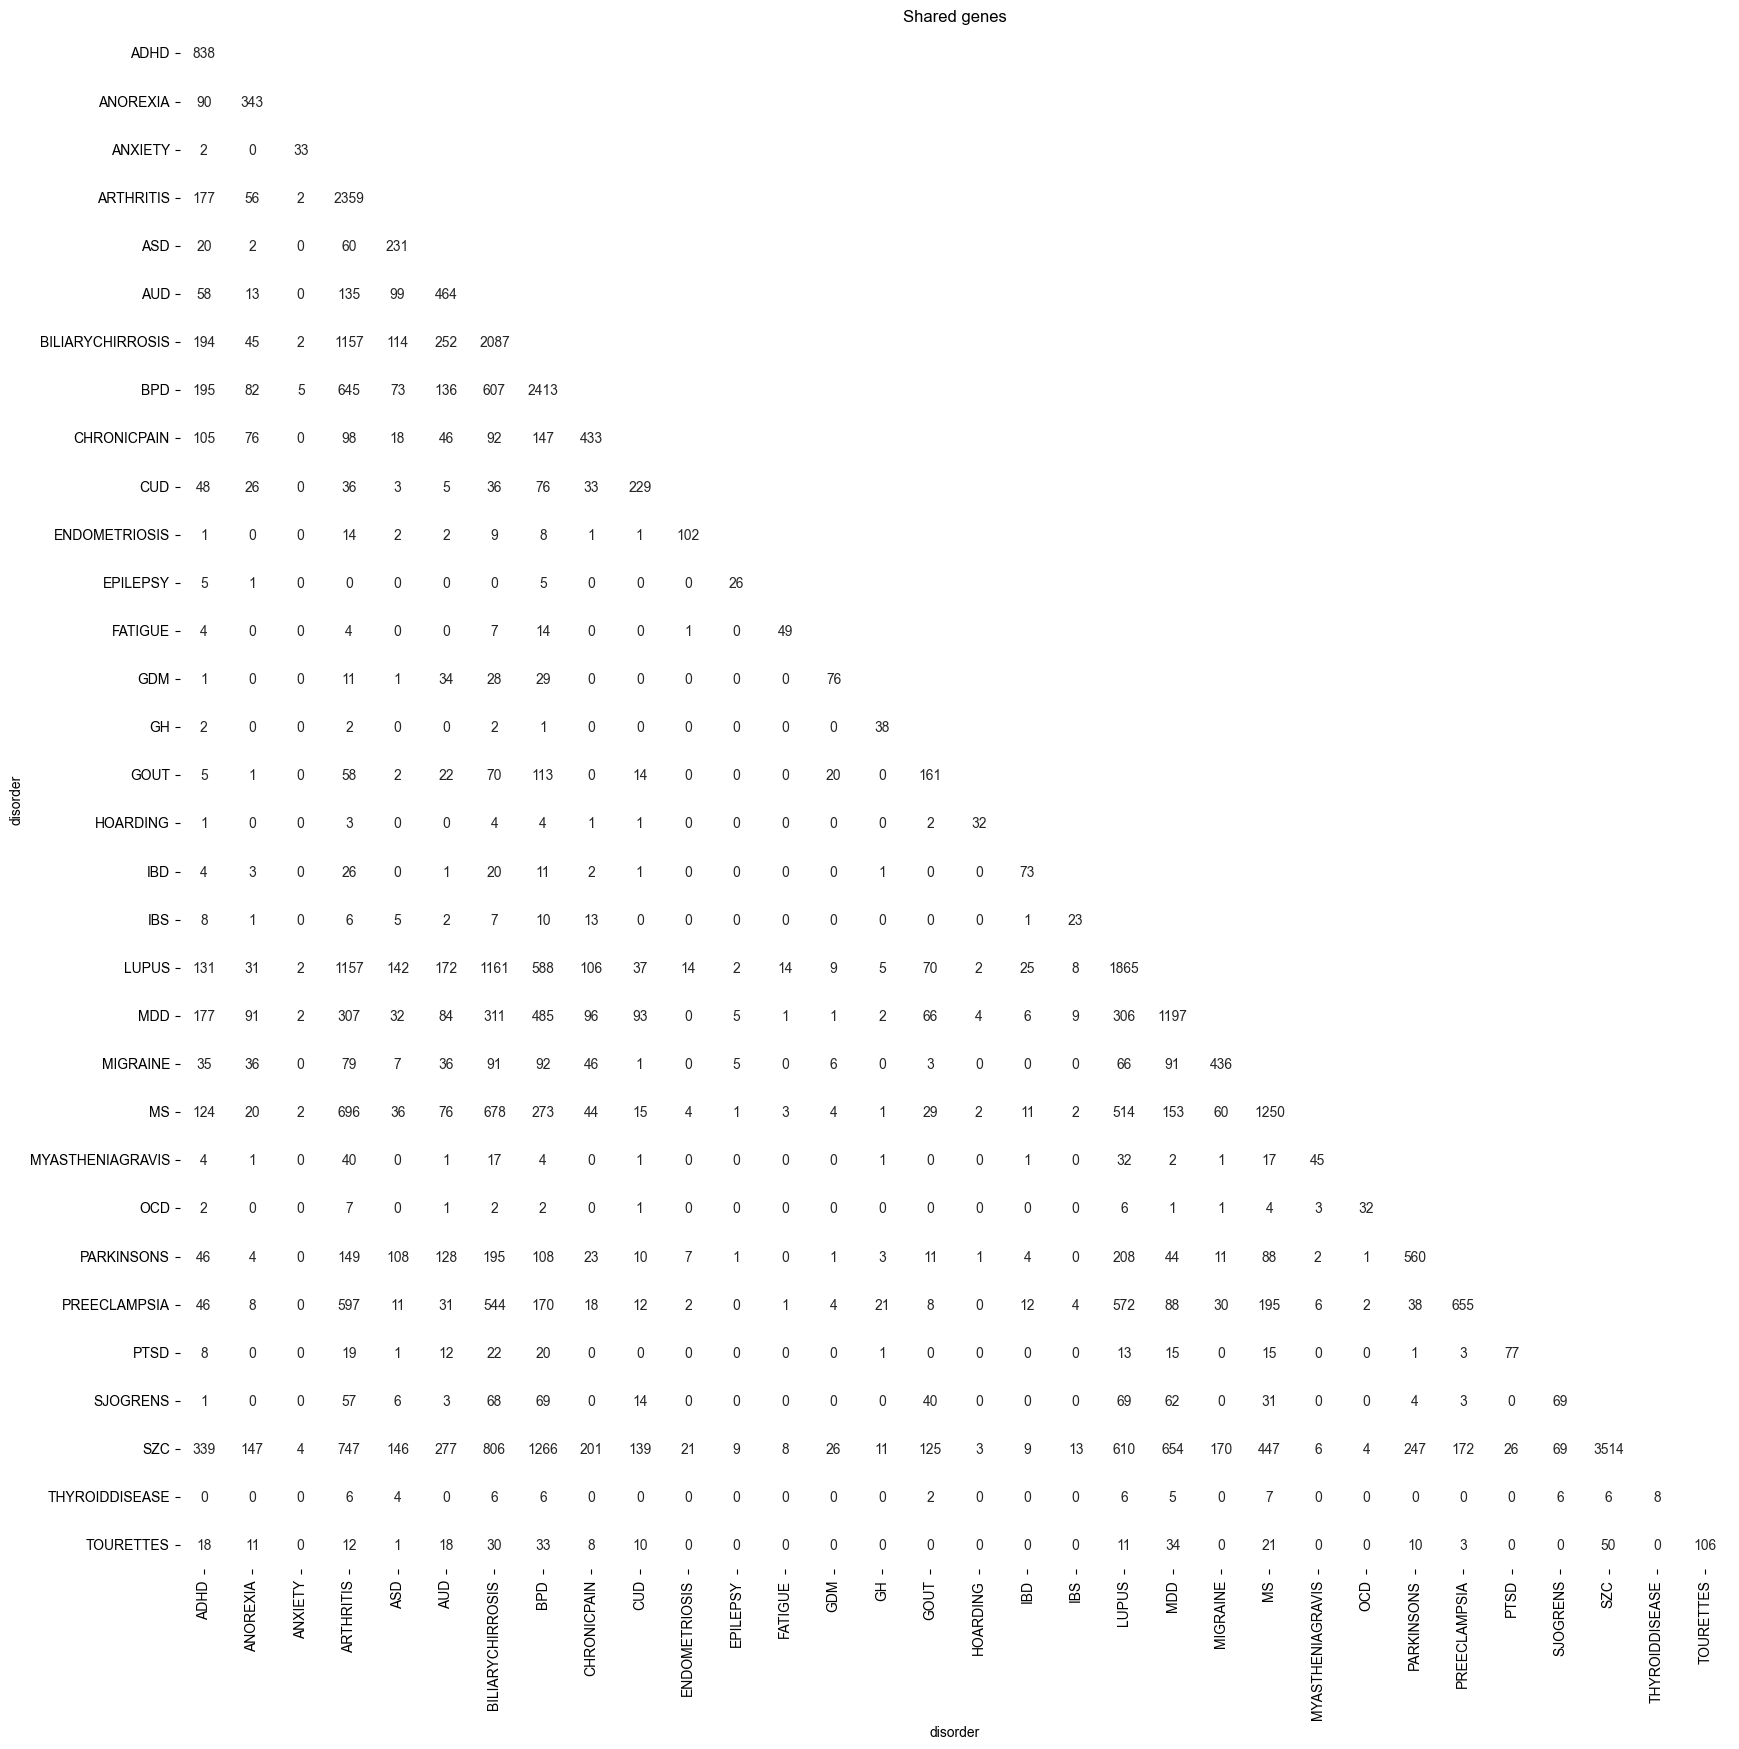

In [48]:
shared_genes = pd.DataFrame(index=all_genes_binary.columns, columns=all_genes_binary.columns, dtype=int)

#Iterate through all pairs of disorders and count genes shared
for disorder1 in all_genes_binary.columns:
    for disorder2 in all_genes_binary.columns:
        count=sum(all_genes_binary[disorder1] & all_genes_binary[disorder2])
        shared_genes.at[disorder1,disorder2] = count

#Add total number of genes in each disorder on the diagonal
for disorder in all_genes_binary.columns:
    total_count = all_genes_binary[disorder].sum()
    shared_genes.at[disorder, disorder] = total_count

#get lower triangular matrix including the diagonal
#shared_lower = pd.DataFrame(np.tril(shared_genes), index=genes_binary.columns, columns=genes_binary.columns)
disorders = shared_genes.columns.tolist()
disorder_matrix = shared_genes.to_numpy()

# Create a mask for the upper triangular part
mask = np.triu(np.ones_like(shared_genes), k=1).astype(bool)

# Set the values in the upper triangular part to NaN
shared_genes[mask] = np.nan

# Specify the size of the heatmap
fig, ax = plt.subplots(figsize=(20,20))

# Plot the heatmap
with sns.axes_style('white'):
    sns.heatmap(shared_genes, annot=True, fmt='.0f', cmap=ListedColormap(['white']), cbar=False)
    plt.title('Shared genes')
    plt.show()

In [ ]:
""" #function to make binary matrix with randobly selected snps
def make_random_binary_matrix(number_i, list_of_snps, number_of_snps):
    random_binary_list = []
    for i in range(number_i):
        random = select_snps_randomly(list_of_snps, number_of_snps)
        concatenated_random = pd.concat(random)
    
        binary = concatenated_random.pivot_table(index='rsID', columns='disorder', aggfunc=lambda x: 1, fill_value=0)
        random_binary_list.append(binary)
    return random_binary_list """


In [49]:

def hypergeometric_prob(matrix, disorder_list, M):

    matrix_shape= matrix.shape
    prob_matrix = np.zeros(matrix_shape)

    for i in range(1, matrix_shape[0]):
        for j in range(i):
            x =matrix[i,j]
            n = matrix[j,j]
            N = matrix[i, i]
            #print(M,n,x)
            
            prob = hypergeom.sf(x-1, M, n, N)
            
                
            prob_matrix[i,j] = prob

    return pd.DataFrame(prob_matrix, columns=disorder_list, index=disorder_list)

   

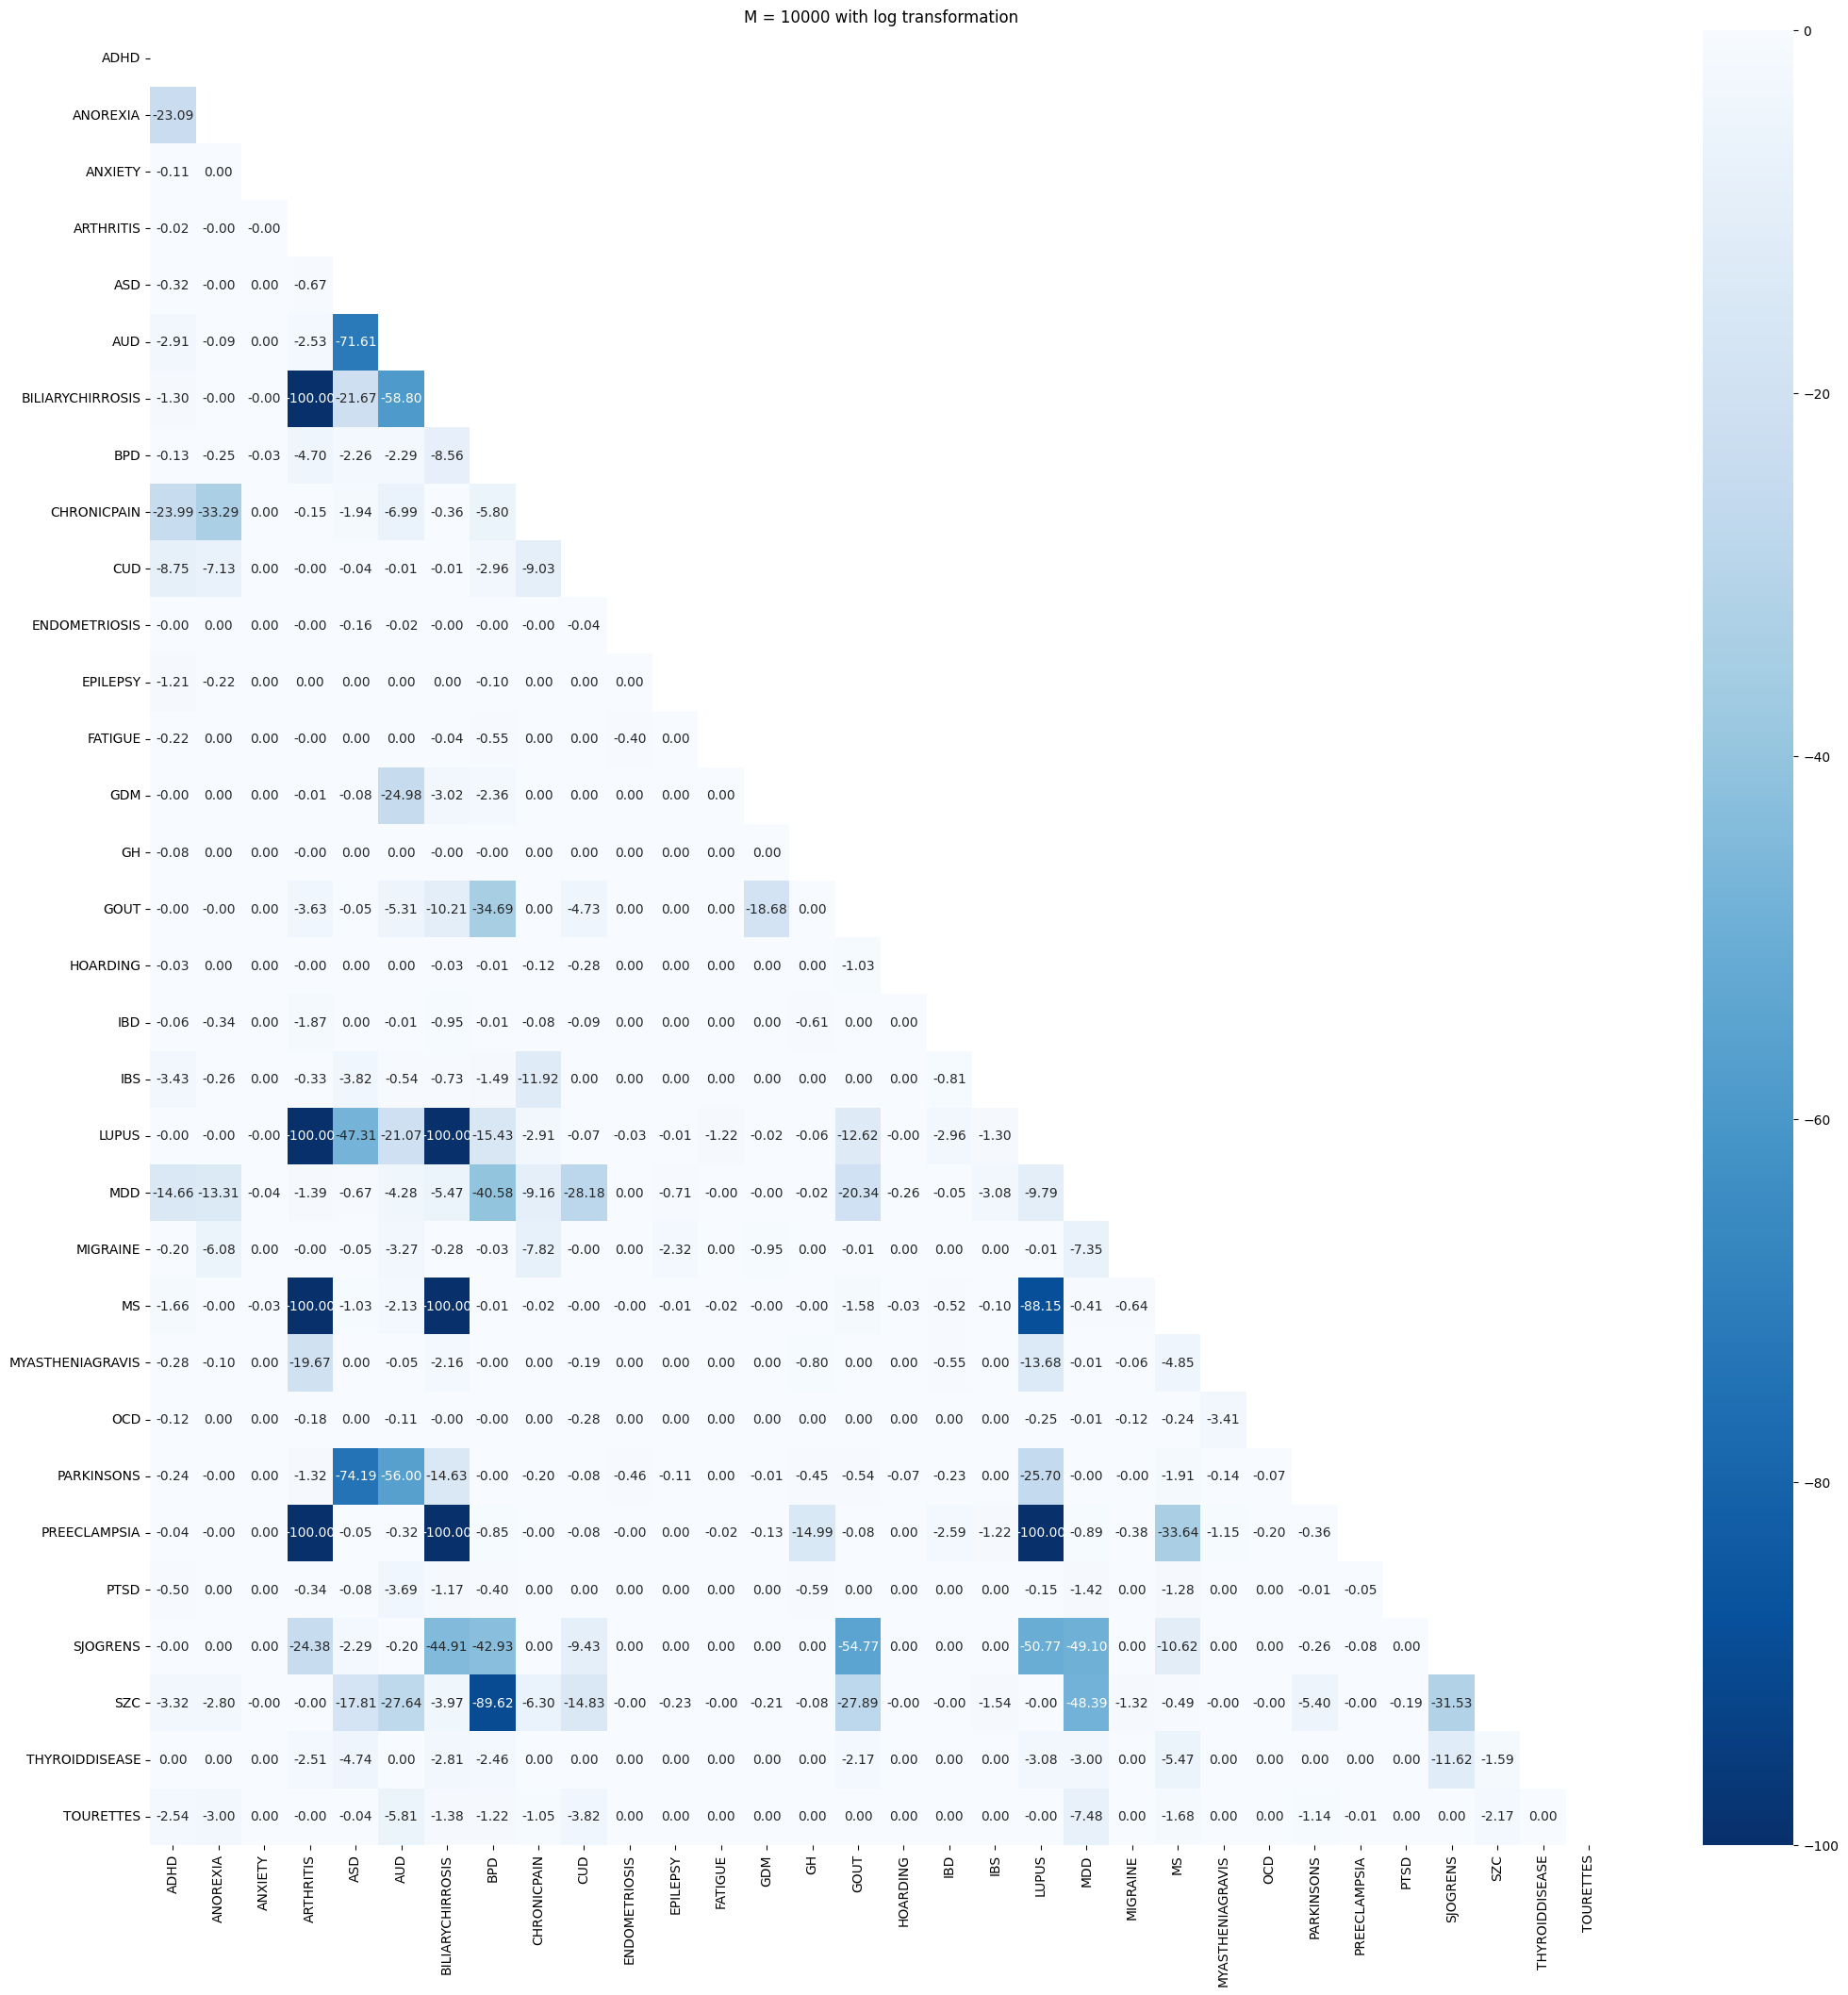

<Figure size 2500x2500 with 0 Axes>

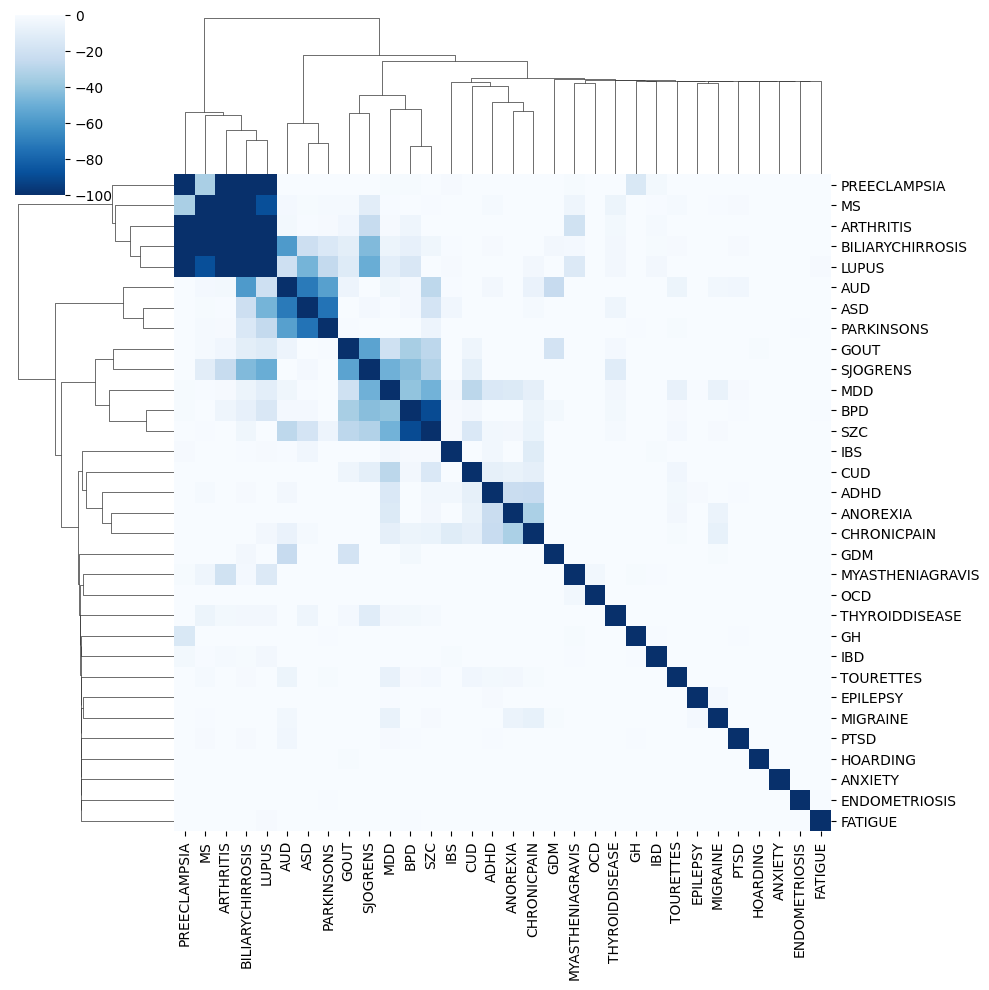

In [50]:
prob_genes_10K=hypergeometric_prob(disorder_matrix, disorders, 10000)
    
# Create a mask for the upper triangular part
mask = np.triu(np.ones_like(prob_genes_10K, dtype=bool))

# Set the upper triangular part to NaN to exclude it from the plot
prob_genes_10K = prob_genes_10K.mask(mask)

#Apply log transformation
prob_genes_10K_log = np.log10(prob_genes_10K+1e-100)

#reverse colormap
cmap = 'Blues'
cmap_reversed = cmap + '_r'

fig, ax = plt.subplots(figsize=(25,25))
plt.title('M = 10000 with log transformation')
sns.heatmap(prob_genes_10K_log, annot=True,fmt='.2f',cmap=cmap_reversed, cbar=True)

prob_genes_10Kfull_matrix = np.tril(prob_genes_10K) + np.tril(prob_genes_10K, -1).T

prob_genes_10Kfull_df = pd.DataFrame(prob_genes_10Kfull_matrix, index=disorders, columns=disorders)
prob_genes_10Kfull_df = prob_genes_10Kfull_df.fillna(1e-100)
prob_genes_10Kfull_df_log = np.log10(prob_genes_10Kfull_df + 1e-100)

plt.figure(figsize=(25,25))
sns.clustermap(prob_genes_10Kfull_df_log,cmap=cmap_reversed)

plt.show()

    
    

In [ ]:
finngen = pd.read_csv('FinnGen/FinnGen_table_all_diseases.csv', sep=';', index_col=0)
disorder_list = finngen.index.values.tolist()
fin_matrix = finngen.to_numpy()
full_finngen_matrix2 = np.tril(finngen) + np.tril(finngen, -1).T
finngen2 = pd.DataFrame(full_finngen_matrix2, index=disorder_list, columns=disorder_list)

# Create a mask for the diagonal
diagonal_mask = np.eye(len(finngen2), dtype=bool)
mask = np.triu(np.ones_like(finngen2, dtype=bool), k=1)

plt.figure(figsize=(25,20))
with sns.axes_style('white'):
    sns.heatmap(finngen2,cmap=ListedColormap(['white']), annot=True, fmt='.0f', mask=mask, cbar=False)
    plt.show()

In [ ]:
finngen_p = hypergeometric_prob(fin_matrix,disorder_list, 500000)

# Create a mask for the upper triangular part
mask = np.triu(np.ones_like(finngen_p, dtype=bool))

# Set the upper triangular part to NaN to exclude it from the plot
finngen_p = finngen_p.mask(mask)

#Apply log transformation
finngen_log = np.log10(finngen_p+1e-300)

#reverse colormap
cmap = 'Blues'
cmap_reversed = cmap + '_r'

fig, ax = plt.subplots(figsize=(25,20))
plt.title('FinnGen with log transformation')
sns.heatmap(finngen_log, annot=True,fmt='.2f',cmap=cmap_reversed, cbar=True)

full_finngen_matrix = np.tril(finngen_p) + np.tril(finngen_p, -1).T
full_finngen_df = pd.DataFrame(full_finngen_matrix, index=disorder_list, columns=disorder_list)
full_finngen_df = full_finngen_df.fillna(1e-300)
full_finngen_log = np.log10(full_finngen_df+1e-300)
plt.figure(figsize=(20,15))
sns.clustermap(full_finngen_log,cmap=cmap_reversed)
plt.show()


In [ ]:
plt.figure(figsize=(20,15))
sns.clustermap(full_finngen_log,cmap=cmap_reversed, method='ward')
plt.show()

In [ ]:
plt.figure(figsize=(20,15))
sns.clustermap(full_finngen_log,cmap=cmap_reversed, method='single')
plt.show()

In [ ]:
plt.figure(figsize=(20,15))
sns.clustermap(full_finngen_log,cmap=cmap_reversed, method='complete')
plt.show()